Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247


Load Data

In [3]:
# subject data
subject = 9
X_test, y_test, X_train_valid, y_train_valid = import_data_subject(subject)


# DeepConv, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [0.9180], Training accuracy [60.97%]
Epoch [10], Validation loss [2.7775], Validation accuracy [23.40%]
Epoch [20], Training loss [0.7257], Training accuracy [70.31%]
Epoch [20], Validation loss [3.4550], Validation accuracy [25.53%]
Epoch [30], Training loss [0.6042], Training accuracy [76.38%]
Epoch [30], Validation loss [3.7222], Validation accuracy [26.31%]
Epoch [40], Training loss [0.4554], Training accuracy [82.26%]
Epoch [40], Validation loss [3.6603], Validation accuracy [32.69%]
Epoch [50], Training loss [0.3563], Training accuracy [86.71%]
Epoch [50], Validation loss [3.4119], Validation accuracy [35.59%]
Epoch [60], Training loss [0.2704], Training accuracy [90.91%]
Epoch [60], Validation loss [3.0117], Validation accuracy [38.88%]
Epoch [70], Training loss [0.2106], Training accuracy [92.89%]
Epoch [70], Validation loss [2.6331], Validation accuracy [53.19%]
Epoch [80], Training loss [0.1463], Training accuracy [96.00%]
Epoch [80]

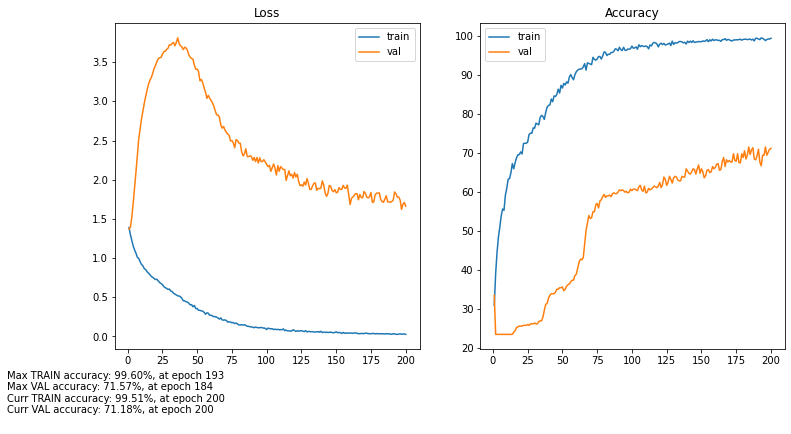

In [4]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3302], Training accuracy [43.58%]
Epoch [10], Validation loss [1.4047], Validation accuracy [19.15%]
Epoch [20], Training loss [1.1571], Training accuracy [55.19%]
Epoch [20], Validation loss [1.4628], Validation accuracy [25.53%]
Epoch [30], Training loss [0.9852], Training accuracy [59.93%]
Epoch [30], Validation loss [1.5518], Validation accuracy [25.53%]
Epoch [40], Training loss [0.8689], Training accuracy [63.98%]
Epoch [40], Validation loss [1.6798], Validation accuracy [25.53%]
Epoch [50], Training loss [0.7833], Training accuracy [65.91%]
Epoch [50], Validation loss [1.8684], Validation accuracy [25.53%]
Epoch [60], Training loss [0.6963], Training accuracy [71.64%]
Epoch [60], Validation loss [2.0779], Validation accuracy [25.53%]
Epoch [70], Training loss [0.6410], Training accuracy [73.76%]
Epoch [70], Validation loss [2.2529], Validation accuracy [25.53%]
Epoch [80], Training loss [0.5696], Training accuracy [77.22%]
Epoch [80]

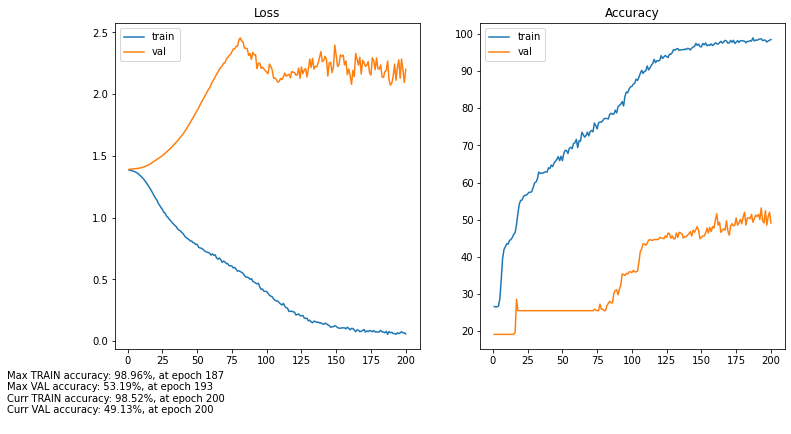

In [5]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv1, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.0615], Training accuracy [53.95%]
Epoch [10], Validation loss [1.8669], Validation accuracy [17.02%]
Epoch [20], Training loss [0.8417], Training accuracy [63.49%]
Epoch [20], Validation loss [2.1120], Validation accuracy [18.57%]
Epoch [30], Training loss [0.6584], Training accuracy [73.86%]
Epoch [30], Validation loss [2.0904], Validation accuracy [19.73%]
Epoch [40], Training loss [0.5117], Training accuracy [79.69%]
Epoch [40], Validation loss [1.9526], Validation accuracy [32.50%]
Epoch [50], Training loss [0.4071], Training accuracy [83.55%]
Epoch [50], Validation loss [1.7146], Validation accuracy [43.71%]
Epoch [60], Training loss [0.2810], Training accuracy [90.17%]
Epoch [60], Validation loss [1.5767], Validation accuracy [54.35%]
Epoch [70], Training loss [0.2146], Training accuracy [92.89%]
Epoch [70], Validation loss [1.4880], Validation accuracy [60.15%]
Epoch [80], Training loss [0.1670], Training accuracy [94.27%]
Epoch [80]

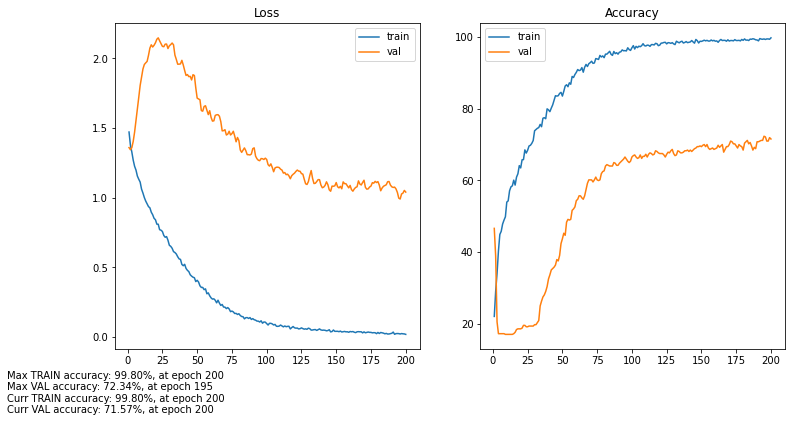

In [6]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv1(dropout=0.5, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# Conv2, trialsize 900, stride 10

-- Fold [1/5] --
Epoch [10], Training loss [1.3769], Training accuracy [28.71%]
Epoch [10], Validation loss [1.3951], Validation accuracy [15.67%]
Epoch [20], Training loss [1.3212], Training accuracy [42.00%]
Epoch [20], Validation loss [1.3520], Validation accuracy [35.20%]
Epoch [30], Training loss [1.1232], Training accuracy [52.22%]
Epoch [30], Validation loss [1.2310], Validation accuracy [38.10%]
Epoch [40], Training loss [0.9938], Training accuracy [59.14%]
Epoch [40], Validation loss [1.1808], Validation accuracy [45.45%]
Epoch [50], Training loss [0.8308], Training accuracy [68.53%]
Epoch [50], Validation loss [1.1866], Validation accuracy [43.33%]
Epoch [60], Training loss [0.6785], Training accuracy [73.81%]
Epoch [60], Validation loss [1.1654], Validation accuracy [47.78%]
Epoch [70], Training loss [0.5857], Training accuracy [77.52%]
Epoch [70], Validation loss [1.1443], Validation accuracy [51.45%]
Epoch [80], Training loss [0.5347], Training accuracy [77.96%]
Epoch [80]

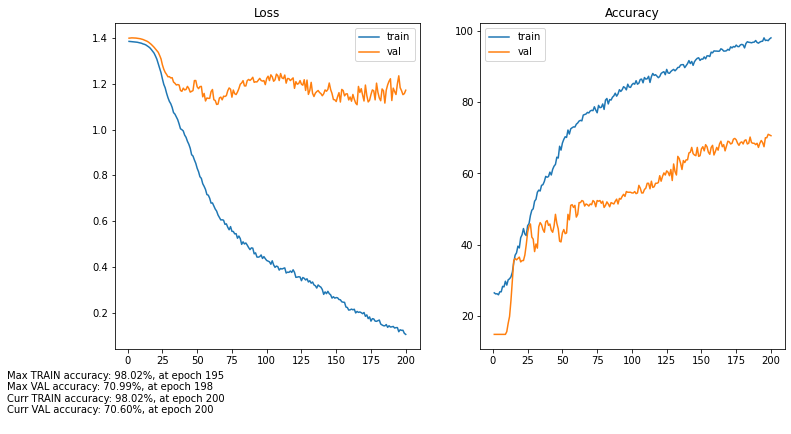

In [7]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 10
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = Conv2(dropout=0.5).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))